In [1]:
import torch
import torch.nn as nn
import os
import torch.utils.data as data
from importlib import import_module
import matplotlib.pyplot as plt

vggish_input=import_module(".torchvggish.vggish_input","torchvggish-master")


#GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
#損失関数
criterion = nn.CrossEntropyLoss()


vggish/embedding:0
Using cuda device


In [2]:
model = torch.hub.load('torchvggish-master', 'vggish', source='local', preprocess=False).to(device)
model.eval()

vggish/embedding:0


VGGish(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [3]:
class MyClassfilter(nn.Module):
    def __init__(self):
        super(MyClassfilter, self).__init__()
        self.classfilter=nn.Sequential(
            nn.Linear(128,64),
            nn.Sigmoid(),
            nn.Linear(64,5),
            nn.Softmax()
        )
    def forward(self, x):
        return self.classfilter(x)
mymodel = MyClassfilter().to(device)
mymodel.eval()

MyClassfilter(
  (classfilter): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=5, bias=True)
    (3): Softmax(dim=None)
  )
)

In [4]:
# 学習済みの重みを使用
use_pretrained = True

# モデルをロード
print(model)
print(mymodel)

VGGish(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [5]:
#試しに実行
#model.eval()# 評価しない
#import urllib
#url, filename = ("http://soundbible.com/grab.php?id=1698&type=wav", "bus_chatter.wav")
#try: urllib.URLopener().retrieve(url, filename)
#except: urllib.request.urlretrieve(url, filename)
#a =model.forward(filename)
#rint(a.size(),a.dim())
#print(mymodel.forward(a))

In [1]:
#データセットの定義？
classes=["Speech","Music"]
dataset_dir="GetAudiosetSample/result"


def make_path_list():
    train_file_list=[]
    valid_file_list=[]
    for i in range(len(classes)):
        dir_name=os.path.join(dataset_dir,classes[i]).replace("\\","/")
        file_list=os.listdir(dir_name)
        
        #8割を学習用、残りを検証用にする
        num_data = len(file_list)
        num_split = int(num_data*0.8)
        
        train_file_list += [[os.path.join(dir_name, file).replace('\\', '/'), i] for file in file_list[:num_split] ]
        valid_file_list += [[os.path.join(dir_name, file).replace('\\', '/'), i] for file in file_list[num_split:]]
    return {"train":train_file_list,"valid":valid_file_list}
# 画像データへのファイルパスとラベルを格納したリストを取得する
path_dict = make_path_list()
## リストが変かもなのでみてみる


print('学習データファイル数 : ', len(path_dict["train"]))
##### 先頭3件だけ表示
print(path_dict["train"][:3])

print('検証データファイル数 : ', len(path_dict["valid"]))
##### 先頭3件だけ表示
print(path_dict["valid"][:3])

NameError: name 'os' is not defined

In [ ]:
#0830
#DataSet型を作る必要がある気がする
class MyDataset(data.Dataset):
    '''
    data_dictは[パス,番号]
    '''
    def __init__(self, path_dict,  phase='train'):
        #self.data_dict = data_dict
        self.data_dict = []
        for path, label in path_dict:
            try:
                for data in vggish_input.wavfile_to_examples(path):
                    #print(1)
                    self.data_dict.append([data, label])
            except:
                print("miss!")
                
        
        self.phase = phase
        
    def __len__(self):
        return len(self.data_dict)
    
    def __getitem__(self,index):
        
        wav_data,label = self.data_dict[index]
        
        return wav_data, label






In [ ]:
#DataSetを実際に作ってみる 

train_dataset = MyDataset(
    path_dict=path_dict["train"],
    phase="train"
)

valid_dataset = MyDataset(
    path_dict=path_dict["valid"],
    phase="valid"
)

In [ ]:
print("学習用データ数 : ", len(train_dataset))
print("検証用データ数 : ", len(valid_dataset))

In [ ]:
#dataloaderを用いてミニバッチを作成
batch_size=100

train_dataloader=data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle=True
)
valid_dataloader=data.DataLoader(
    valid_dataset, batch_size = batch_size//2, shuffle=True
)

dataloader_dict={
    'train': train_dataloader, 
    'valid': valid_dataloader
}
print(dataloader_dict)

In [ ]:
#dataloader_dictを保存
import joblib

# 保存
joblib.dump(dataloader_dict, "dataloader_dict.jb", compress=3)

#読み出し
hoge = joblib.load("dataloader_dict.jb")
print(hoge)

In [7]:
#読み出し
import joblib
hoge = joblib.load("dataloader_dict.jb")
print(hoge)


{'train': <torch.utils.data.dataloader.DataLoader object at 0x0000024902BBCCA0>, 'valid': <torch.utils.data.dataloader.DataLoader object at 0x00000249470C1FD0>}


In [8]:
dataloader_dict=hoge

In [9]:
# パラメータ名の確認
for name, param in model.named_parameters():
    print('name : ', name)
print("-------")
for name, param in mymodel.named_parameters():
    print("name : ",name)
#print(mymodel.parameters())

name :  features.0.weight
name :  features.0.bias
name :  features.3.weight
name :  features.3.bias
name :  features.6.weight
name :  features.6.bias
name :  features.8.weight
name :  features.8.bias
name :  features.11.weight
name :  features.11.bias
name :  features.13.weight
name :  features.13.bias
name :  embeddings.0.weight
name :  embeddings.0.bias
name :  embeddings.2.weight
name :  embeddings.2.bias
name :  embeddings.4.weight
name :  embeddings.4.bias
name :  pproc.pca_eigen_vectors
name :  pproc.pca_means
-------
name :  classfilter.0.weight
name :  classfilter.0.bias
name :  classfilter.2.weight
name :  classfilter.2.bias


In [10]:
#学習させるパラメータを格納
params_to_update=[]
#学習させるパラメータ名
update_param_names=['classfilter.0.weight', 'classfilter.0.bias', 'classfilter.2.weight','classfilter.2.bias']

#対象以外は購買計算をせず、変化しないようにもする
for name,param in mymodel.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print("name : ",name)
    else:
        param.requires_grad = False


name :  classfilter.0.weight
name :  classfilter.0.bias
name :  classfilter.2.weight
name :  classfilter.2.bias


In [11]:
import torch.optim as optim
#勾配計算手法?
#optimizer = optim.SGD(params_to_update, lr=0.01)
optimizer = optim.SGD(params_to_update, lr=0.01)

In [12]:
#エポック数
num_epochs=300
x=[]
y=[]
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1,num_epochs))
    
    for phase in ['train','valid']:
        if phase == 'train':
            mymodel.train()#学習モード
        else:
            mymodel.eval()#検証モード
    
        #epoch全体の損失の輪と正解数
        epoch_loss=0.0
        epoch_corrects=0
        
        count=0.0
        #print(phase)
        for inputs, labels in dataloader_dict[phase]:
            #入力の確認
            #print(len(inputs),len(labels))
            #optimizer?を初期化?する?
            optimizer.zero_grad()


            with torch.set_grad_enabled(phase=='train'):

                out1=model(inputs)
                outputs=mymodel(out1)

                #labelsをcudaに
                labels=labels.to(device)

                #損失関数を計算
                loss=criterion(outputs, labels)
                #ラベルを予測
                _,preds = torch.max(outputs,1)
                
                #訓練時は逆伝搬の計算
                if phase == "train":
                    #逆伝搬
                    loss.backward()
                    
                    #パラメータ更新
                    optimizer.step()
                
                #イテレーション結果の計算
                #lossの合計を更新
                #pytorchの使用上バッチ内の平均lossが計算されているのでデータ数をかけて合計にする
                #損失和を「全データの損失/データ数」で求めるせいらしい?
                #print(len(inputs))
                epoch_loss += loss.item() * inputs.size(0)
                
                #正解数の合計を更新
                epoch_corrects += torch.sum(preds == labels.data)

        #epochのlossと正解数の表示
        epoch_loss=epoch_loss/len(dataloader_dict[phase].dataset)
        epoch_acc=epoch_corrects.double()/len(dataloader_dict[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        x.append(epoch_acc)
        y.append(epoch)
        


Epoch 1/300


C:\Users\hase\anaconda3\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 1.4141 Acc: 0.5786
valid Loss: 1.3376 Acc: 0.6781
Epoch 2/300
train Loss: 1.3029 Acc: 0.7068
valid Loss: 1.2938 Acc: 0.7275
Epoch 3/300
train Loss: 1.2478 Acc: 0.7611
valid Loss: 1.2356 Acc: 0.7587
Epoch 4/300
train Loss: 1.2048 Acc: 0.7838
valid Loss: 1.2051 Acc: 0.7621
Epoch 5/300
train Loss: 1.1758 Acc: 0.7906
valid Loss: 1.1731 Acc: 0.7816
Epoch 6/300
train Loss: 1.1556 Acc: 0.7986
valid Loss: 1.1612 Acc: 0.7868
Epoch 7/300
train Loss: 1.1414 Acc: 0.8018
valid Loss: 1.1513 Acc: 0.7859
Epoch 8/300
train Loss: 1.1312 Acc: 0.8040
valid Loss: 1.1446 Acc: 0.7924
Epoch 9/300
train Loss: 1.1237 Acc: 0.8065
valid Loss: 1.1408 Acc: 0.7847
Epoch 10/300
train Loss: 1.1194 Acc: 0.8087
valid Loss: 1.1295 Acc: 0.7970
Epoch 11/300
train Loss: 1.1148 Acc: 0.8105
valid Loss: 1.1380 Acc: 0.7884
Epoch 12/300
train Loss: 1.1122 Acc: 0.8097
valid Loss: 1.1251 Acc: 0.7998
Epoch 13/300
train Loss: 1.1075 Acc: 0.8136
valid Loss: 1.1401 Acc: 0.7797
Epoch 14/300
train Loss: 1.1092 Acc: 0.8133
va

KeyboardInterrupt: 

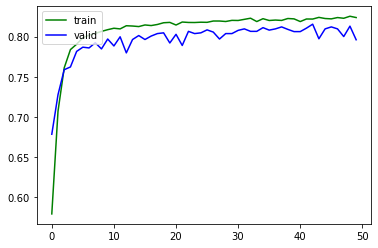

In [14]:
plt.plot(y[:100:2],[i.tolist() for i in x][:100:2], label="train", color ="Green")
plt.plot(y[:100:2],[i.tolist() for i in x][1:100:2], label="valid", color ="Blue")
plt.legend(loc='upper left')